<a href="https://colab.research.google.com/github/maragraziani/InterpretabilityVISUM22/blob/main/def_VISUM_XAI_Tutorial.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**VISUM 2022 - Exaplainable AI - Hands on session**
# Explainability for Vision Models
**led by Mara Graziani**
* postdoctoral researcher at Hes-so Valais and IBM Research x ZHAW
* mara.graziani@hevs.ch ; @mormontre

Content

1.  Gradient based methods: Gradient-weighted Class Activation Maps (Grad-CAM)
and Integrated Gradients
2.  Model agnostic: LIME and Sharp-LIME
3.  Concept-based post-hoc attribution

## Introduction 

## Take Aways

*   List item
*   List item

### Acknowledgements and References

### Exploring further
If you want to further dive into the research in Interpretable AI, do not hesitate to look into the following toolboxes:
- Captum
- Explainable AI 360
- Quantus. I would like to thank Anna Hedström (<hedstroem.anna@gmail.com>) for her insights on XAI evaluation toolbox that she developed. For any questions concerning Quantus feel free to directly reach out to her. 


### Installation and Set up


In [1]:
!pip install captum opencv-python 
#!pip install torch==1.8.0+cu111 torchvision==0.9.0+cu111 -f https://download.pytorch.org/whl/torch_stable.html

In [2]:
!git clone https://github.com/maragraziani/InterpretabilityVISUM22.git

fatal: destination path 'InterpretabilityVISUM22' already exists and is not an empty directory.


In [3]:
import sys
import warnings
import numpy as np
import torch
import torchvision
from torchvision import transforms, datasets
import os
import cv2
import PIL
from IPython.display import clear_output
import json
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(font_scale=1.25)
plt.style.use('seaborn-white')
plt.rcParams['ytick.labelleft'] = True
plt.rcParams['xtick.labelbottom'] = True
torch.cuda.empty_cache()
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu") 
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=DeprecationWarning)

clear_output()

In [4]:
!wget -P $HOME/.torch/models https://s3.amazonaws.com/deep-learning-models/image-models/imagenet_class_index.json
labels_path = os.getenv("HOME") + '/.torch/models/imagenet_class_index.json'
with open(labels_path) as json_data:
    idx_to_labels = json.load(json_data)

--2022-05-16 15:54:27--  https://s3.amazonaws.com/deep-learning-models/image-models/imagenet_class_index.json
Resolving s3.amazonaws.com (s3.amazonaws.com)... 52.216.30.78
Connecting to s3.amazonaws.com (s3.amazonaws.com)|52.216.30.78|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 35363 (35K) [application/octet-stream]
Saving to: ‘/root/.torch/models/imagenet_class_index.json.3’

imagenet_class_inde 100%[===================>]  34.53K  --.-KB/s    in 0.002s  

2022-05-16 15:54:27 (17.5 MB/s) - ‘/root/.torch/models/imagenet_class_index.json.3’ saved [35363/35363]



In [5]:
transform = transforms.Compose([
 transforms.Resize(256),
 transforms.CenterCrop(224),
 transforms.ToTensor()
])

transform_normalize = transforms.Normalize(
     mean=[0.485, 0.456, 0.406],
     std=[0.229, 0.224, 0.225]
 )

In [6]:
# Loading the model 
model = torchvision.models.densenet201(pretrained=True)
model = model.eval()

# Creating wrapper to access gradient values
class DenseNet(torch.nn.Module):
    def __init__(self):
        super(DenseNet, self).__init__()
        
        # get the pretrained DenseNet201 network
        self.densenet = torchvision.models.densenet201(pretrained=True)
        
        # disect the network to access its last convolutional layer
        self.features_conv = self.densenet.features
        
        # add the average global pool
        self.global_avg_pool = torch.nn.AvgPool2d(kernel_size=7, stride=1)
        
        # get the classifier of the vgg19
        self.classifier = self.densenet.classifier
        
        # placeholder for the gradients
        self.gradients = None
    
    # hook for the gradients of the activations
    def activations_hook(self, grad):
        self.gradients = grad
        
    def forward(self, x):
        x = self.features_conv(x)
        
        # register the hook
        h = x.register_hook(self.activations_hook)
        
        # don't forget the pooling
        x = self.global_avg_pool(x)
        x = x.view((1, 1920))
        x = self.classifier(x)
        return x
    
    def get_activations_gradient(self):
        return self.gradients
    
    def get_activations(self, x):
        return self.features_conv(x)

""" deprecated for now
class ResNet18(torch.nn.Module):
    def __init__(self, model):
        super(ResNet18, self).__init__()
        
        # get the pretrained  network
        self.model = model#torchvision.models.resnet18(pretrained=True)
        
        # disect the network to access its last convolutional layer
        self.features_conv = self.model.layer4
        
        # get the max pool of the features stem
        #self.max_pool = torch.nn.MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
        self.global_avg_pool = torch.nn.AvgPool2d(kernel_size=7, stride=1)
        
        # get the classifier of the vgg19
        self.classifier = self.model.fc
        
        # placeholder for the gradients
        self.gradients = None
    
    # hook for the gradients of the activations
    def activations_hook(self, grad):
        self.gradients = grad
        
    def forward(self, x):
        x = self.features_conv(x)
        
        # register the hook
        h = x.register_hook(self.activations_hook)
        
        # apply the remaining pooling
        x = self.max_pool(x)
        x = x.view((1, -1))
        x = self.classifier(x)
        return x
    
    # method for the gradient extraction
    def get_activations_gradient(self):
        return self.gradients
    
    # method for the activation exctraction
    def get_activations(self, x):
        return self.features_conv(x)
"""

' deprecated for now\nclass ResNet18(torch.nn.Module):\n    def __init__(self, model):\n        super(ResNet18, self).__init__()\n        \n        # get the pretrained  network\n        self.model = model#torchvision.models.resnet18(pretrained=True)\n        \n        # disect the network to access its last convolutional layer\n        self.features_conv = self.model.layer4\n        \n        # get the max pool of the features stem\n        #self.max_pool = torch.nn.MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)\n        self.global_avg_pool = torch.nn.AvgPool2d(kernel_size=7, stride=1)\n        \n        # get the classifier of the vgg19\n        self.classifier = self.model.fc\n        \n        # placeholder for the gradients\n        self.gradients = None\n    \n    # hook for the gradients of the activations\n    def activations_hook(self, grad):\n        self.gradients = grad\n        \n    def forward(self, x):\n        x = self.features_conv(x)\n   

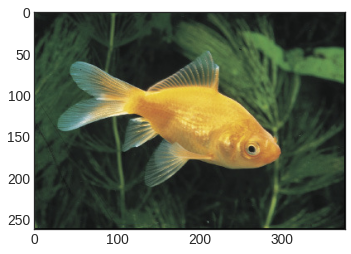

In [7]:
# load imagenet sample and apply standard transforms
imagenet_samples_dir = "/content/InterpretabilityVISUM22/data/"
img = PIL.Image.open(imagenet_samples_dir+'n01443537/n01443537_goldfish.JPEG')
plt.imshow(img)
transformed_img = transform(img)
input = transform_normalize(transformed_img)
input = input.unsqueeze(0)
#plt.imshow(np.swapaxes(np.asarray(input[0]), 0,2))

In [8]:
images=[]
for image_dir in os.listdir(imagenet_samples_dir):
  if ".md" not in image_dir:
    for image_path in os.listdir(os.path.join(imagenet_samples_dir,image_dir)):
        dir_=os.path.join(imagenet_samples_dir,image_dir)
        image = PIL.Image.open(os.path.join(dir_, image_path))
        #transformed_img = transform(img)
        #input = transform_normalize(transformed_img)
        #input = input.unsqueeze(0)
        images.append(image) 
#transformed_inputs=torch.stack(tuple(transform_normalize(i) for i in images), dim=0)

### 1A. Grad-CAM

#### Theory

#### Practice


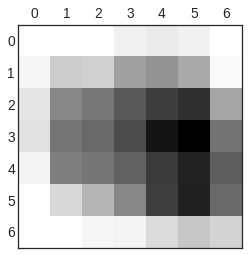

In [ ]:
# generating prediction from wrapped model
densenet = DenseNet()
pred = densenet(input)
class_idx = pred.argmax(dim=1).item()
pred[:, class_idx].backward()

# getting the gradients
gradients = densenet.get_activations_gradient()

# pooling the gradients across the channels
pooled_gradients = torch.mean(gradients, dim=[0, 2, 3])

# geting the activations of the last convolutional layer
activations = densenet.get_activations(input).detach()

# weighting the channels by corresponding gradients
for i in range(512):
    activations[:, i, :, :] *= pooled_gradients[i]
    
# averaging the channels of the activations
heatmap = torch.mean(activations, dim=1).squeeze()

# relu on top of the heatmap
# expression (2) in https://arxiv.org/pdf/1610.02391.pdf
heatmap = np.maximum(heatmap, 0)

# normalizing the heatmap
heatmap /= torch.max(heatmap)

# visualization
plt.matshow(heatmap.squeeze())

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


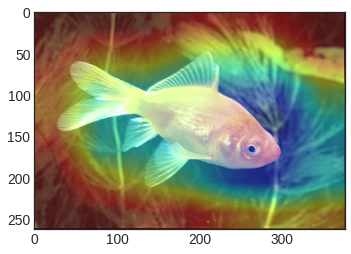

In [ ]:
# Mapping back to the original input image
img=np.asarray(img, dtype=np.float32)
heatmap = cv2.resize(np.asarray(heatmap), (img.shape[1], img.shape[0]))
heatmap = np.uint8(255 * heatmap)
heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
superimposed_img = heatmap * 0.4 + img
cv2.imwrite('./map.jpg', superimposed_img)
plt.imshow(np.asarray(superimposed_img, dtype=np.int))

#### Exercises

> Indented block





## 1B. Integrated Gradients with Captum

#### Theory

#### Practice

In [ ]:
import captum
from matplotlib.colors import LinearSegmentedColormap
from captum.attr import visualization as viz
from captum.attr import IntegratedGradients

del model
# Loading the model 
model = torchvision.models.densenet201(pretrained=True)
model = model.eval()
output = model(input)
output = torch.nn.functional.softmax(output, dim=1)
prediction_score, pred_label_idx = torch.topk(output, 1)

pred_label_idx.squeeze_()
predicted_label = idx_to_labels[str(pred_label_idx.item())][1]

print('Predicted:', predicted_label, '(', prediction_score.squeeze().item(), ')')

integrated_gradients = IntegratedGradients(model)
attributions_ig = integrated_gradients.attribute(input, target=pred_label_idx, n_steps=50)


Predicted: goldfish ( 0.9041939973831177 )


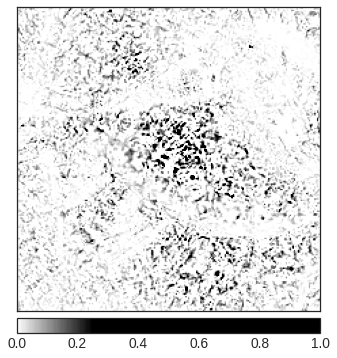

In [ ]:
default_cmap = LinearSegmentedColormap.from_list('custom blue', 
                                                 [(0, '#ffffff'),
                                                  (0.25, '#000000'),
                                                  (1, '#000000')], N=256)

_ = viz.visualize_image_attr(np.transpose(attributions_ig.squeeze().cpu().detach().numpy(), (1,2,0)),
                             np.transpose(transformed_img.squeeze().cpu().detach().numpy(), (1,2,0)),
                             method='heat_map',
                             cmap=default_cmap,
                             show_colorbar=True,
                             sign='positive',
                             outlier_perc=1)

In [ ]:
noise_tunnel = NoiseTunnel(integrated_gradients)

attributions_ig_nt = noise_tunnel.attribute(input, nt_samples=10, nt_type='smoothgrad_sq', target=pred_label_idx)
_ = viz.visualize_image_attr_multiple(np.transpose(attributions_ig_nt.squeeze().cpu().detach().numpy(), (1,2,0)),
                                      np.transpose(transformed_img.squeeze().cpu().detach().numpy(), (1,2,0)),
                                      ["original_image", "heat_map"],
                                      ["all", "positive"],
                                      cmap=default_cmap,
                                      show_colorbar=True)


#### Exercises


## 2. Local Interpretable Model-agnostic Explanations (LIME)


In [ ]:
!pip install lime

Predicted: red_wine ( 0.7952153086662292 )


  0%|          | 0/200 [00:00<?, ?it/s]

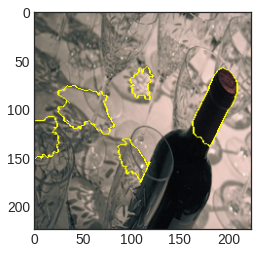

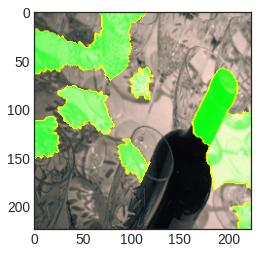

In [9]:
from lime import lime_image
from skimage.segmentation import mark_boundaries

def get_pil_transform(): 
    transf = transforms.Compose([
        transforms.Resize((256, 256)),
        transforms.CenterCrop(224)
    ])    

    return transf
pill_transf = get_pil_transform()

def get_preprocess_transform():
    normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                    std=[0.229, 0.224, 0.225])     
    transf = transforms.Compose([
        transforms.ToTensor(),
        normalize
    ]) 
    return transf
preprocess_transform = get_preprocess_transform()

def batch_predict(images):
    model.eval()
    batch = torch.stack(tuple(preprocess_transform(i) for i in images), dim=0)
    #batch = torch.stack(tuple(preprocess_transform(i) for i in images), dim=0)
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    batch = batch.to(device)
    
    logits = model(batch)
    probs = torch.nn.functional.softmax(logits, dim=1)
    return probs.detach().cpu().numpy()

image_idx=1
input_img = transform_normalize(transform(images[image_idx])).unsqueeze(0)
output = model(input_img)
output = torch.nn.functional.softmax(output, dim=1)
prediction_score, pred_label_idx = torch.topk(output, 1)

pred_label_idx.squeeze_()
predicted_label = idx_to_labels[str(pred_label_idx.item())][1]

print('Predicted:', predicted_label, '(', prediction_score.squeeze().item(), ')')


explainer = lime_image.LimeImageExplainer()

explanation = explainer.explain_instance(np.asarray(pill_transf(images[image_idx])),
                                         batch_predict, # classification function
                                         top_labels=5, 
                                         hide_color=0, 
                                         num_samples=200) # number of images that will be sent to classification function


temp, mask = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=True, num_features=5, hide_rest=False)
img_boundry1 = mark_boundaries(temp/255.0, mask)
plt.figure()
plt.imshow(img_boundry1)
print()
temp, mask = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=False, num_features=10, hide_rest=False)
img_boundry2 = mark_boundaries(temp/255.0, mask)
plt.figure()
plt.imshow(img_boundry2)

### Sharpening Local Interpretable Model-Agnostic Explanations (Sharp-LIME)

In [7]:
!git clone https://github.com/maftouni/binary_mask_from_json.git

fatal: destination path 'binary_mask_from_json' already exists and is not an empty directory.


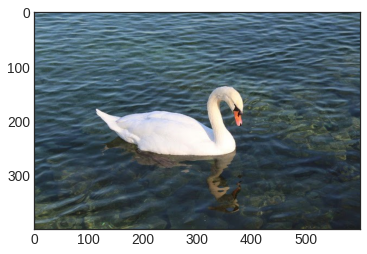

In [10]:
img = PIL.Image.open("/content/binary_mask_from_json/sample_frames/adutta_swan.jpg")
plt.imshow(img)
transformed_img = transform(img)
input = transform_normalize(transformed_img)
input = input.unsqueeze(0)

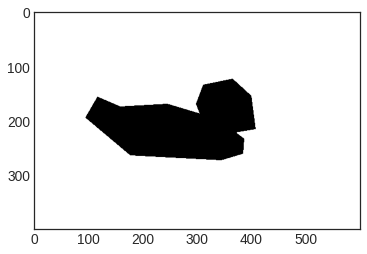

In [11]:
mask = np.asarray(PIL.Image.open("/content/binary_mask_from_json/binary_masks/00000.png"))
plt.imshow(mask)

In [12]:
mask2 = mask.copy()
mask2[:,:300] = 0

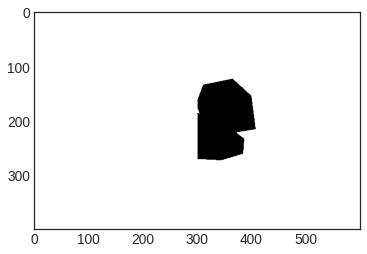

In [13]:
plt.imshow(mask2)

In [14]:
del model
model = torchvision.models.densenet201(pretrained=True)
model = model.eval()
output = model(input)
output = torch.nn.functional.softmax(output, dim=1)
prediction_score, pred_label_idx = torch.topk(output, 1)

pred_label_idx.squeeze_()
predicted_label = idx_to_labels[str(pred_label_idx.item())][1]

print('Predicted:', predicted_label, '(', prediction_score.squeeze().item(), ')')

Predicted: goose ( 0.6745553016662598 )


In [15]:
from lime import lime_image
def segfunc(img):
        return np.asarray(np.ones(mask.shape)-mask, dtype=np.int)
predict=model(input)
def batch_predict(images):
    model.eval()
    batch = torch.stack(tuple(transform_normalize(transform(PIL.Image.fromarray(i))) for i in images), dim=0)

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    batch = batch.to(device)
    
    probs = model(batch)
    #probs = torch.nn.functional.softmax(logits, dim=1)
    return probs.detach().cpu().numpy()
#quickshift_segs = segments_quickshift(im)
#Generate LIME explanation for class 1
explainer = lime_image.LimeImageExplainer()
class_idx = pred_label_idx.item()
explanation_genetic = explainer.explain_instance(np.asarray(img), 
                                                batch_predict, 
                                                  segmentation_fn = None,
                                                     top_labels=3,#Just making sure we generate explanations for both classes. Any number >2 should work. 
                                                     hide_color=0,#Cover superpixels in black. 
                                                     num_samples=20,
                                                     progress_bar=False)

In [16]:
dict_genetic = dict(explanation_genetic.local_exp[class_idx])
heatmap = np.vectorize(dict_genetic.get)(explanation_genetic.segments)
orig_rank=sorted(dict_genetic, key=dict_genetic.get, reverse=True)

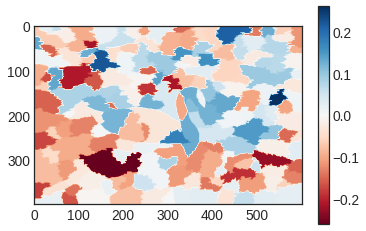

In [17]:
plt.imshow(np.vectorize(dict_genetic.get)(explanation_genetic.segments), cmap = 'RdBu', vmin=-heatmap.max(), vmax = heatmap.max())
plt.colorbar()

In [18]:
explanation_genetic = explainer.explain_instance(np.asarray(img), 
                                                batch_predict, 
                                                  segmentation_fn = segfunc,
                                                     top_labels=3,#Just making sure we generate explanations for both classes. Any number >2 should work. 
                                                     hide_color=0,#Cover superpixels in black. 
                                                     num_samples=20,
                                                     progress_bar=False)

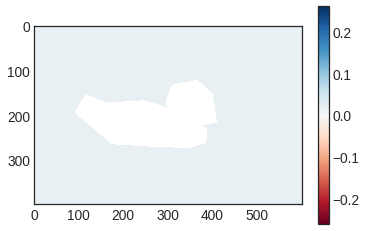

In [19]:
plt.imshow(np.vectorize(dict_genetic.get)(explanation_genetic.segments), cmap = 'RdBu', vmin=-heatmap.max(), vmax = heatmap.max())
plt.colorbar()

In [20]:
def segfunc(img):
        return np.asarray(np.ones(mask.shape)-mask2, dtype=np.int)

explanation_genetic = explainer.explain_instance(np.asarray(img), 
                                                batch_predict, 
                                                  segmentation_fn = segfunc,
                                                     top_labels=3,#Just making sure we generate explanations for both classes. Any number >2 should work. 
                                                     hide_color=0,#Cover superpixels in black. 
                                                     num_samples=20,
                                                     progress_bar=False)

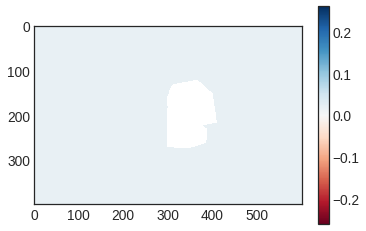

In [21]:
plt.imshow(np.vectorize(dict_genetic.get)(explanation_genetic.segments), cmap = 'RdBu', vmin=-heatmap.max(), vmax = heatmap.max())
plt.colorbar()

In [22]:
#def get_segments(mask):
squares = np.zeros(mask.shape[:2])
fract = int(mask.shape[0]/6)
fract1=int(mask.shape[1]/6)
counter = 0
for hor in range(6):
    for ver in range(6):
        squares[fract*hor:fract*(hor+1),fract1*ver:fract1*(ver+1)]=counter
        counter+=1

segments = (np.ones(mask.shape)-mask/5.) + squares
#print(np.unique(segments))

temp_renumber = [2+item for item in list(range(len(np.unique(segments))))]

renumbering_map = dict(zip(np.unique(segments),temp_renumber))

segments = np.vectorize(renumbering_map.get)(segments)
segments = np.where(segments.copy()==8,squares,segments)

def segfunc(img):
        return segments
explanation_genetic = explainer.explain_instance(np.asarray(img), 
                                                batch_predict, 
                                                  segmentation_fn = segfunc,
                                                     top_labels=3,#Just making sure we generate explanations for both classes. Any number >2 should work. 
                                                     hide_color=0,#Cover superpixels in black. 
                                                     num_samples=20,
                                                     progress_bar=False)

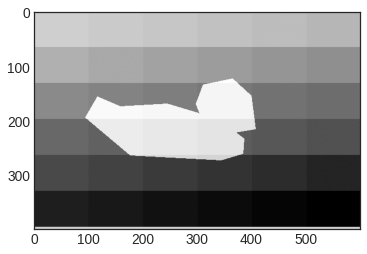

In [23]:
plt.imshow(segments)

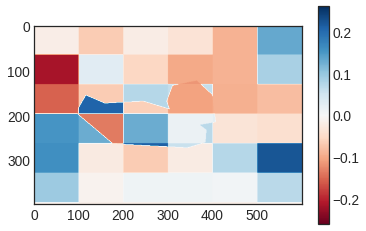

In [24]:
plt.imshow(np.vectorize(dict_genetic.get)(explanation_genetic.segments), cmap = 'RdBu', vmin=-heatmap.max(), vmax = heatmap.max())
plt.colorbar()